In [1]:
import sys,os,time,ast

In [2]:
sys.path.append("../src/")

In [3]:
import opendvp.filtering

In [4]:
import opendvp.anndata_utils

In [17]:
adata = opendvp.anndata_utils.read_quant("../data/TNBC_subset/quant/TD_15_TNBC_subset.csv")

2025-03-02 16:01:34.784 | INFO     | opendvp.anndata_utils:read_quant:16 -  ---- read_quant : version number 1.1.0 ----
2025-03-02 16:01:34.840 | INFO     | opendvp.anndata_utils:read_quant:36 -  16808 cells and 15 variables
2025-03-02 16:01:34.840 | INFO     | opendvp.anndata_utils:read_quant:37 -  ---- read_quant is done, took 0s  ----


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

2025-03-02 16:01:35.609 | INFO     | __main__:filter_by_annotation_sjoin:11 -  ---- filter_by_annotation : version number 2.0.1 ----
2025-03-02 16:01:35.610 | INFO     | __main__:filter_by_annotation_sjoin:12 -  Each class of annotation will be a different column in adata.obs
2025-03-02 16:01:35.611 | INFO     | __main__:filter_by_annotation_sjoin:13 -  TRUE means cell was inside annotation, FALSE means cell not in annotation
2025-03-02 16:01:35.616 | INFO     | __main__:filter_by_annotation_sjoin:20 - GeoJson loaded, detected: 8 annotations


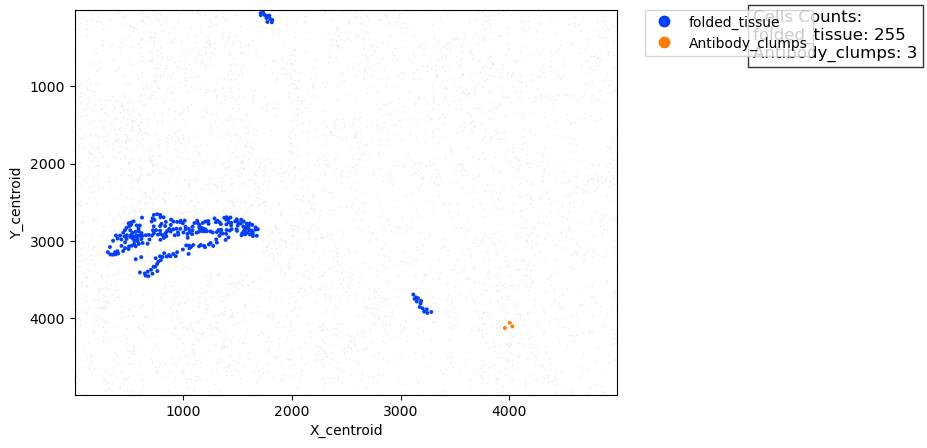

In [18]:
adata = filter_by_annotation_sjoin(adata=adata, path_to_geojson="../data/TNBC_subset/geojsons/TD_15_TNBC_subset_artefact_annotations.geojson")

In [19]:
adata

AnnData object with n_obs × n_vars = 16808 × 15
    obs: 'CellID', 'Y_centroid', 'X_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Orientation', 'Extent', 'Solidity', 'Antibody_clumps', 'folded_tissue', 'artefact'
    var: 'math', 'marker'

In [13]:
import time
import geopandas as gpd
import shapely.geometry
import anndata as ad
import pandas as pd
from loguru import logger

def filter_by_annotation_sjoin(adata, path_to_geojson, any_label="artefact", plot_QC=True) -> ad.AnnData:
    """ Filter cells by annotation in a geojson file efficiently using spatial indexing """

    logger.info(" ---- filter_by_annotation : version number 2.0.1 ----")
    logger.info(" Each class of annotation will be a different column in adata.obs")
    logger.info(" TRUE means cell was inside annotation, FALSE means cell not in annotation")
    
    # Load GeoJSON
    gdf = gpd.read_file(path_to_geojson)
    assert gdf.geometry is not None, "No geometry found in the geojson file"
    assert gdf.geometry.type.unique()[0] == 'Polygon', "Only polygon geometries are supported"
    
    logger.info(f"GeoJson loaded, detected: {len(gdf)} annotations")

    # Extract class names
    gdf['class_name'] = gdf['classification'].apply(lambda x: ast.literal_eval(x).get('name') if isinstance(x, str) else x.get('name'))

    # Convert AnnData cell centroids to a GeoDataFrame
    points_gdf = gpd.GeoDataFrame(adata.obs.copy(), 
                                  geometry=gpd.points_from_xy(adata.obs['X_centroid'], adata.obs['Y_centroid']),
                                  crs=gdf.crs)  # Assume same CRS
    
    joined = gpd.sjoin(points_gdf, gdf[['geometry', 'class_name']], how='left', predicate='within')
    
    df_grouped = joined.groupby("CellID")['class_name'].agg(lambda x: list(set(x))).reset_index() #fails here
    df_expanded = df_grouped.copy()
    for cat in set(cat for sublist in df_grouped['class_name'] for cat in sublist):
        df_expanded[cat] = df_expanded['class_name'].apply(lambda x: cat in x)
    
    df_expanded.drop(columns=['class_name', np.nan], inplace=True)
    df_expanded[any_label] = df_expanded.drop(columns=["CellID"]).any(axis=1)
    category_cols = [col for col in df_expanded.columns if col not in ["CellID", any_label]]
    df_expanded["annotation"] = df_expanded[category_cols].apply(lambda row: next((col for col in category_cols if row[col]), None), axis=1)

    adata.obs = pd.merge(adata.obs, df_expanded, on="CellID")

    if plot_QC:

        #plotting
        labels_to_plot = list(gdf.class_name.unique())
        max_x, max_y = adata.obs[['X_centroid', 'Y_centroid']].max()
        min_x, min_y = adata.obs[['X_centroid', 'Y_centroid']].min()

        tmp_df_ann = adata.obs[adata.obs['annotation'].isin(labels_to_plot)]
        tmp_df_notann = adata.obs[~adata.obs['annotation'].isin(labels_to_plot)].sample(frac=0.2, random_state=0).reset_index(drop=True)

        fig, ax = plt.subplots(figsize=(7,5))
        sns.scatterplot(data=tmp_df_notann, x='X_centroid', y='Y_centroid', linewidth=0, s=2, alpha=0.1)
        sns.scatterplot(data=tmp_df_ann, x='X_centroid', y='Y_centroid', hue='annotation', palette='bright', linewidth=0, s=8)

        plt.xlim(min_x, max_x)
        plt.ylim(max_y, min_y)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=3)

        # Show value counts
        value_counts = tmp_df_ann['annotation'].value_counts()
        value_counts_str = "\n".join([f"{cat}: {count}" for cat, count in value_counts.items()])

        plt.gca().text(1.25, 1, f"Cells Counts:\n{value_counts_str}",
                transform=plt.gca().transAxes, 
                fontsize=12, 
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

        plt.show()

        #drop object columns ( this would block saving to h5ad)
        adata.obs = adata.obs.drop(columns=['annotation'])

    return adata

In [2]:
sdata = spatialdata.read_zarr("../data/sdata/20241209_1525_sdata_full.zarr")

/opt/homebrew/Caskroom/mambaforge/base/envs/spatialdata/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/opt/homebrew/Caskroom/mambaforge/base/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/homebrew/Caskroom/mambaforge/base/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [17]:
gdf = gpd.read_file("../data/geojsons/991_manual_annotations/991.geojson")

In [ ]:
# for manual annotations I want to annotate an anndata or anndata inside sdata

In [5]:
import shapely

In [ ]:
from loguru import logger
import time
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import shapely
import geopandas as gpd
import ast


def filter_by_annotation(adata, path_to_geojson, x_centroid='X_centroid', y_centroid="Y_centroid") -> ad.AnnData:
    """ Filter cells by annotation in a geojson file """
    
    logger.info(" ---- filter_by_annotation : version number 1.3.0 ----")
    time_start = time.time()
    adata_copy = adata.copy()

    # checks
    assert isinstance(adata_copy, ad.AnnData), "adata should be an anndata object"
    # path to geojson
    assert isinstance(path_to_geojson, str), "path_to_geojson must be a string"
    assert path_to_geojson.endswith('.geojson'), "path_to_geojson must end with .geojson"
    assert os.path.isfile(path_to_geojson), f"path_to_geojson {path_to_geojson} not found"

    #load gdf
    gdf = gpd.read_file(path_to_geojson)
    assert gdf.geometry is not None, "No geometry found in the geojson file"
    logger.info(f"GeoJson loaded, detected: {len(gdf)} annotations")
    gdf['class_name'] = gdf['classification'].apply(lambda x: ast.literal_eval(x).get('name'))
    gdf['RGB_color'] = gdf['classification'].apply(lambda x: ast.literal_eval(x).get('color'))

    # function to check if a point is inside a list of polygons, and return value from a column
    # TODO this will not return a list if a point is inside multiple polygons
    def label_point_if_inside_polygon(point, gdf, key='class_name'):
        for i, polygon in enumerate(gdf.geometry):
            if polygon.contains(point):
                return gdf.iloc[i][key]
        return 'None'
    
    adata_copy.obs['point_geometry'] = adata_copy.obs.apply(lambda x: shapely.geometry.Point(x[x_centroid], x[y_centroid]), axis=1)
    adata_copy.obs['polygon_class'] = adata_copy.obs['point_geometry'].apply(lambda cell: label_point_if_inside_polygon(cell, gdf, key='class_name'))

    unique_classes = gdf['class_name'].unique()
    #remove False from unique_classes
    logger.info(f"Unique annotation classes in geojson: {unique_classes}")

    # assuming that we want to create a different boolean column for each class
    # Where TRUE always represents a cell that was found inside the annotation 
    for class_name in unique_classes:
        logger.info(f"Creating column {class_name}")
        adata_copy.obs[class_name] = False
        adata_copy.obs[class_name] = adata_copy.obs['polygon_class'] == class_name

    #plotting
    max_x, max_y = adata_copy.obs[['X_centroid', 'Y_centroid']].max()
    # problem
    tmp_df_ann = adata_copy.obs[adata_copy.obs['polygon_class'] != "None"]
    tmp_df_Keep = adata_copy.obs[adata_copy.obs['polygon_class'] == "None"].sample(frac=0.2, random_state=0).reset_index(drop=True)

    sns.scatterplot(data=tmp_df_Keep, x='X_centroid', y='Y_centroid', hue='polygon_class', palette='grey', linewidth=0, s=3, alpha=0.1)
    sns.scatterplot(data=tmp_df_ann, x='X_centroid', y='Y_centroid', hue='polygon_class', palette='bright', linewidth=0, s=8)

    plt.xlim(0, max_x)
    plt.ylim(max_y, 0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=3)

    # Show value counts
    value_counts = tmp_df_ann['polygon_class'].value_counts()
    value_counts_str = "\n".join([f"{cat}: {count}" for cat, count in value_counts.items()])

    plt.gca().text(1.35, 1, f"Cells Counts:\n{value_counts_str}",
            transform=plt.gca().transAxes, 
            fontsize=12, 
            verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

    plt.show()

    logger.info(f" ---- filter_by_annotation is done, took {int(time.time() - time_start)}s  ----")
    return adata


2024-12-09 18:26:38.225 | INFO     | __main__:filter_by_annotation:15 -  ---- filter_by_annotation : version number 1.3.0 ----
2024-12-09 18:26:38.487 | INFO     | __main__:filter_by_annotation:29 - GeoJson loaded, detected: 17 annotations
2024-12-09 18:27:38.844 | INFO     | __main__:filter_by_annotation:46 - Unique annotation classes in geojson: ['991']
2024-12-09 18:27:38.847 | INFO     | __main__:filter_by_annotation:51 - Creating column 991


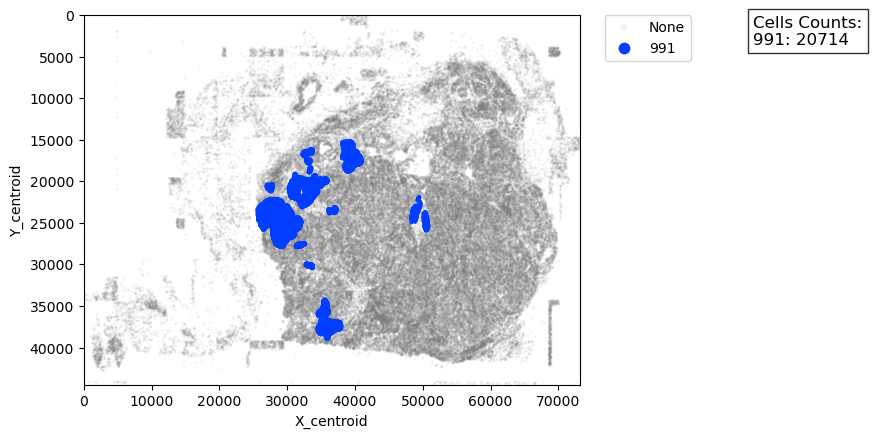

KeyError: "['point_geometry'] not found in axis"

In [95]:
adata2 = filter_by_annotation(
    adata=sdata['imaging'],
    path_to_geojson="../data/geojsons/991_manual_annotations/991.geojson",
)

In [81]:
gdf = gpd.read_file("../data/geojsons/991_manual_annotations/991.geojson")
df = sdata['imaging'].obs.copy()

In [83]:
gdf.head()

,id,objectType,classification,geometry
0,9392dcd1-6401-44be-971b-5d9cf9aa80ee,annotation,"{ ""name"": ""991"", ""color"": [ 207, 243, 172 ] }","POLYGON ((35588 19594, 35571.33 19595.67, 3557..."
1,77af69f7-a28d-41f8-94b9-b395e34dbac7,annotation,"{ ""name"": ""991"", ""color"": [ 207, 243, 172 ] }","POLYGON ((49514 21885, 49482 21887, 49468.29 2..."
2,e2d4aa05-3ef3-40ff-8e89-ab370b370708,annotation,"{ ""name"": ""991"", ""color"": [ 207, 243, 172 ] }","POLYGON ((50337 23664, 50305 23666, 50291.29 2..."
3,13e19294-4b0e-4679-a354-f0d0de808b5e,annotation,"{ ""name"": ""991"", ""color"": [ 207, 243, 172 ] }","POLYGON ((35531 34205, 35497 34209, 35465 3421..."
4,22a26c99-cfc3-4b9e-99f2-64bf8d5b23b1,annotation,"{ ""name"": ""991"", ""color"": [ 207, 243, 172 ] }","POLYGON ((32437 27401, 32403 27405, 32393.4 27..."


In [84]:
df.head()

,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,Solidity,region
1,1,29410.806452,35874.857801,1519.0,98.696620,30.646839,0.950568,-1.524977,228.651804,0.676615,poly_mask
2,2,29445.080408,36162.243140,1567.0,50.422862,39.687556,0.616832,0.160002,148.710678,0.975109,poly_mask
3,3,29505.171707,38455.235122,1025.0,40.280587,34.195207,0.528513,-0.346644,131.438600,0.927602,poly_mask
4,4,29539.721673,35060.844867,1315.0,61.049935,28.208869,0.886848,-1.447088,151.254834,0.947406,poly_mask
5,5,29982.642779,36765.660558,3656.0,84.178897,57.384893,0.731630,0.251203,243.379726,0.926743,poly_mask


In [85]:
gdf['class_name'] = gdf['classification'].apply(lambda x: ast.literal_eval(x).get('name'))
gdf['RGB_color'] = gdf['classification'].apply(lambda x: ast.literal_eval(x).get('color'))
gdf.head()

,id,objectType,classification,geometry,class_name,RGB_color
0,9392dcd1-6401-44be-971b-5d9cf9aa80ee,annotation,"{ ""name"": ""991"", ""color"": [ 207, 243, 172 ] }","POLYGON ((35588 19594, 35571.33 19595.67, 3557...",991,"[207, 243, 172]"
1,77af69f7-a28d-41f8-94b9-b395e34dbac7,annotation,"{ ""name"": ""991"", ""color"": [ 207, 243, 172 ] }","POLYGON ((49514 21885, 49482 21887, 49468.29 2...",991,"[207, 243, 172]"
2,e2d4aa05-3ef3-40ff-8e89-ab370b370708,annotation,"{ ""name"": ""991"", ""color"": [ 207, 243, 172 ] }","POLYGON ((50337 23664, 50305 23666, 50291.29 2...",991,"[207, 243, 172]"
3,13e19294-4b0e-4679-a354-f0d0de808b5e,annotation,"{ ""name"": ""991"", ""color"": [ 207, 243, 172 ] }","POLYGON ((35531 34205, 35497 34209, 35465 3421...",991,"[207, 243, 172]"
4,22a26c99-cfc3-4b9e-99f2-64bf8d5b23b1,annotation,"{ ""name"": ""991"", ""color"": [ 207, 243, 172 ] }","POLYGON ((32437 27401, 32403 27405, 32393.4 27...",991,"[207, 243, 172]"


In [86]:
def label_point_if_inside_polygon(point, gdf, key='class_name'):
    for i, polygon in enumerate(gdf.geometry):
        if polygon.contains(point):
            return gdf.iloc[i][key]
    return 'None'

df['point_geometry'] = df.apply(lambda x: shapely.geometry.Point(x['X_centroid'], x['Y_centroid']), axis=1)

In [87]:
df.head()

,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,Solidity,region,point_geometry
1,1,29410.806452,35874.857801,1519.0,98.696620,30.646839,0.950568,-1.524977,228.651804,0.676615,poly_mask,POINT (35874.85780118499 29410.8064516129)
2,2,29445.080408,36162.243140,1567.0,50.422862,39.687556,0.616832,0.160002,148.710678,0.975109,poly_mask,POINT (36162.2431397575 29445.08040842374)
3,3,29505.171707,38455.235122,1025.0,40.280587,34.195207,0.528513,-0.346644,131.438600,0.927602,poly_mask,POINT (38455.23512195122 29505.171707317073)
4,4,29539.721673,35060.844867,1315.0,61.049935,28.208869,0.886848,-1.447088,151.254834,0.947406,poly_mask,POINT (35060.84486692015 29539.7216730038)
5,5,29982.642779,36765.660558,3656.0,84.178897,57.384893,0.731630,0.251203,243.379726,0.926743,poly_mask,POINT (36765.66055798687 29982.642778993435)


In [88]:
df['polygon_class'] = df['point_geometry'].apply(lambda cell: label_point_if_inside_polygon(cell, gdf, key='class_name'))

In [89]:
df.head()

,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,Solidity,region,point_geometry,polygon_class
1,1,29410.806452,35874.857801,1519.0,98.696620,30.646839,0.950568,-1.524977,228.651804,0.676615,poly_mask,POINT (35874.85780118499 29410.8064516129),None
2,2,29445.080408,36162.243140,1567.0,50.422862,39.687556,0.616832,0.160002,148.710678,0.975109,poly_mask,POINT (36162.2431397575 29445.08040842374),None
3,3,29505.171707,38455.235122,1025.0,40.280587,34.195207,0.528513,-0.346644,131.438600,0.927602,poly_mask,POINT (38455.23512195122 29505.171707317073),None
4,4,29539.721673,35060.844867,1315.0,61.049935,28.208869,0.886848,-1.447088,151.254834,0.947406,poly_mask,POINT (35060.84486692015 29539.7216730038),None
5,5,29982.642779,36765.660558,3656.0,84.178897,57.384893,0.731630,0.251203,243.379726,0.926743,poly_mask,POINT (36765.66055798687 29982.642778993435),None


In [90]:
df.polygon_class.value_counts()

polygon_class
None    665091
991      20714
Name: count, dtype: int64

In [91]:
df[df['polygon_class'] == 'None'].head()

,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,Solidity,region,point_geometry,polygon_class
1,1,29410.806452,35874.857801,1519.0,98.696620,30.646839,0.950568,-1.524977,228.651804,0.676615,poly_mask,POINT (35874.85780118499 29410.8064516129),None
2,2,29445.080408,36162.243140,1567.0,50.422862,39.687556,0.616832,0.160002,148.710678,0.975109,poly_mask,POINT (36162.2431397575 29445.08040842374),None
3,3,29505.171707,38455.235122,1025.0,40.280587,34.195207,0.528513,-0.346644,131.438600,0.927602,poly_mask,POINT (38455.23512195122 29505.171707317073),None
4,4,29539.721673,35060.844867,1315.0,61.049935,28.208869,0.886848,-1.447088,151.254834,0.947406,poly_mask,POINT (35060.84486692015 29539.7216730038),None
5,5,29982.642779,36765.660558,3656.0,84.178897,57.384893,0.731630,0.251203,243.379726,0.926743,poly_mask,POINT (36765.66055798687 29982.642778993435),None
